In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import cv2

In [4]:
import kagglehub
# Download dataset
path = kagglehub.dataset_download("jehanbhathena/weather-dataset")
data = path + "/dataset"


In [5]:
import os
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/weather-dataset/dataset/hail/0106.jpg
/kaggle/input/weather-dataset/dataset/hail/0375.jpg
/kaggle/input/weather-dataset/dataset/hail/0285.jpg
/kaggle/input/weather-dataset/dataset/hail/0074.jpg
/kaggle/input/weather-dataset/dataset/hail/0077.jpg
/kaggle/input/weather-dataset/dataset/hail/0498.jpg
/kaggle/input/weather-dataset/dataset/hail/0426.jpg
/kaggle/input/weather-dataset/dataset/hail/0235.jpg
/kaggle/input/weather-dataset/dataset/hail/0273.jpg
/kaggle/input/weather-dataset/dataset/hail/0307.jpg
/kaggle/input/weather-dataset/dataset/hail/0444.jpg
/kaggle/input/weather-dataset/dataset/hail/0058.jpg
/kaggle/input/weather-dataset/dataset/hail/0255.jpg
/kaggle/input/weather-dataset/dataset/hail/0128.jpg
/kaggle/input/weather-dataset/dataset/hail/0364.jpg
/kaggle/input/weather-dataset/dataset/hail/0246.jpg
/kaggle/input/weather-dataset/dataset/hail/0337.jpg
/kaggle/input/weather-dataset/dataset/hail/0208.jpg
/kaggle/input/weather-dataset/dataset/hail/0141.jpg
/kaggle/inpu

In [6]:
image_paths, labels = [], []

for cls in os.listdir(data):
    cls_path = os.path.join(data, cls)
    if os.path.isdir(cls_path):
        for img in os.listdir(cls_path):
            if img.lower().endswith(('.jpg','.png','.jpeg')):
                image_paths.append(os.path.join(cls_path, img))
                labels.append(cls)

df = pd.DataFrame({"filepath": image_paths, "class": labels})

train_df, temp_df = train_test_split(
    df, test_size=0.3, stratify=df["class"], random_state=42
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["class"], random_state=42
)


In [8]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet import preprocess_input

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_gen.flow_from_dataframe(
    train_df, x_col="filepath", y_col="class",
    target_size=(224,224), batch_size=32, class_mode="categorical"
)

valid_generator = val_gen.flow_from_dataframe(
    val_df, x_col="filepath", y_col="class",
    target_size=(224,224), batch_size=32, class_mode="categorical", shuffle=False
)

test_generator = test_gen.flow_from_dataframe(
    test_df, x_col="filepath", y_col="class",
    target_size=(224,224), batch_size=32, class_mode="categorical", shuffle=False
)


Found 4803 validated image filenames belonging to 11 classes.
Found 1029 validated image filenames belonging to 11 classes.
Found 1030 validated image filenames belonging to 11 classes.


Data Distribution:
dew: 489
fogsmog: 596
frost: 332
glaze: 447
hail: 414
lightning: 264
rain: 368
rainbow: 162
rime: 812
sandstorm: 484
snow: 435


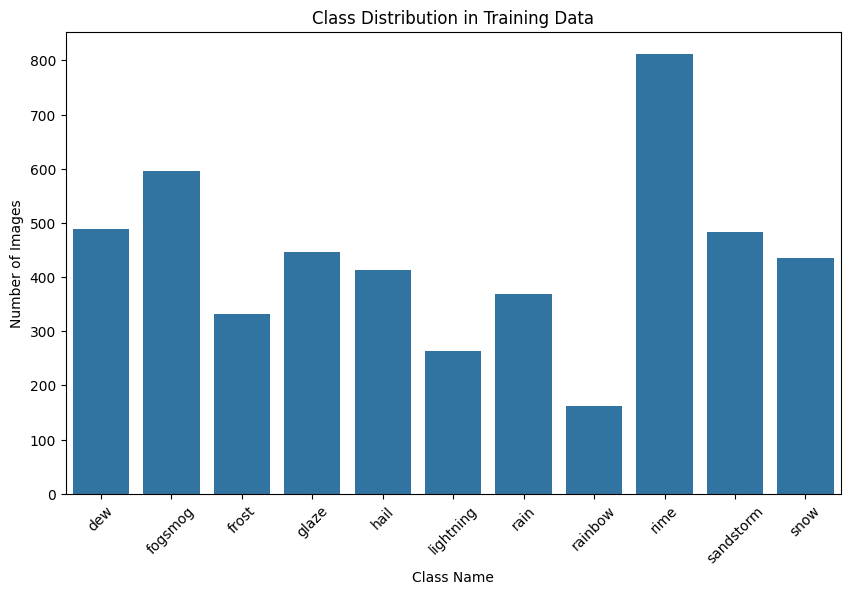


Computed Class Weights (Pass this to model.fit):
{0: np.float64(0.8929168990518683), 1: np.float64(0.7326113483831604), 2: np.float64(1.315169769989047), 3: np.float64(0.9768151311775473), 4: np.float64(1.0546772068511199), 5: np.float64(1.6539256198347108), 6: np.float64(1.1865118577075098), 7: np.float64(2.6952861952861955), 8: np.float64(0.5377295118674429), 9: np.float64(0.9021412471825695), 10: np.float64(1.0037617554858935)}


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight

# 1. Get labels from your generator
labels = train_generator.classes
class_indices = train_generator.class_indices # Dictionary of class names
class_names = list(class_indices.keys())

# 2. Calculate distribution
unique, counts = np.unique(labels, return_counts=True)
label_counts = dict(zip(class_names, counts))

print("Data Distribution:")
for name, count in label_counts.items():
    print(f"{name}: {count}")

# 3. Visualize the balance
plt.figure(figsize=(10, 6))
sns.barplot(x=class_names, y=counts)
plt.title('Class Distribution in Training Data')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

# 4. Calculate Balanced Class Weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights_dict = dict(enumerate(weights))

print("\nComputed Class Weights (Pass this to model.fit):")
print(class_weights_dict)


In [12]:
weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(weights))


In [14]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0
import tensorflow as tf
from tensorflow.keras import layers, models

base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)
base_model.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(11, activation="softmax")(x)

model = models.Model(base_model.input, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [15]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.2)
]

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    class_weight=class_weights,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1766500910.507490     143 service.cc:152] XLA service 0x7b3230003720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766500910.507531     143 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766500910.507538     143 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766500912.737313     143 cuda_dnn.cc:529] Loaded cuDNN version 91002
2025-12-23 14:41:59.309595: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-23 14:41:59.452958: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-23 14:41:59.785998: E external/local_xl

130/151 ━━━━━━━━━━━━━━━━━━━━ 11s 562ms/step - accuracy: 0.2834 - loss: 2.0531

2025-12-23 14:43:26.361425: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-23 14:43:26.495194: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-23 14:43:26.796755: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-23 14:43:26.935976: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-23 14:43:27.627353: E external/local_xla/xla/stream_

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.3084 - loss: 2.0000

2025-12-23 14:44:05.538729: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-23 14:44:05.673276: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-23 14:44:05.984721: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-23 14:44:06.124576: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-23 14:44:06.822731: E external/local_xla/xla/stream_

151/151 ━━━━━━━━━━━━━━━━━━━━ 150s 821ms/step - accuracy: 0.3095 - loss: 1.9976 - val_accuracy: 0.7483 - val_loss: 1.0940 - learning_rate: 1.0000e-04
Epoch 2/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 65s 431ms/step - accuracy: 0.7198 - loss: 0.9521 - val_accuracy: 0.8076 - val_loss: 0.7352 - learning_rate: 1.0000e-04
Epoch 3/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 64s 426ms/step - accuracy: 0.7807 - loss: 0.6879 - val_accuracy: 0.8251 - val_loss: 0.5969 - learning_rate: 1.0000e-04
Epoch 4/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 65s 430ms/step - accuracy: 0.8047 - loss: 0.5834 - val_accuracy: 0.8338 - val_loss: 0.5387 - learning_rate: 1.0000e-04
Epoch 5/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 62s 407ms/step - accuracy: 0.8222 - loss: 0.5115 - val_accuracy: 0.8367 - val_loss: 0.4933 - learning_rate: 1.0000e-04
Epoch 6/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 64s 421ms/step - accuracy: 0.8471 - loss: 0.4587 - val_accuracy: 0.8358 - val_loss: 0.4711 - learning_rate: 1.0000e-04
Epoch 7/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 63s 416ms/step -

In [16]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="CNN.weights.h5",
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.001)
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[model_checkpoint_callback, early_stopping, reduce_lr],
    class_weight=class_weights_dict
)


Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.8137 - loss: 0.6019

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_categorical_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


151/151 ━━━━━━━━━━━━━━━━━━━━ 107s 551ms/step - accuracy: 0.8138 - loss: 0.6016 - val_accuracy: 0.8698 - val_loss: 0.4410 - learning_rate: 2.0000e-05
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 63s 418ms/step - accuracy: 0.8556 - loss: 0.4527 - val_accuracy: 0.8707 - val_loss: 0.4407 - learning_rate: 2.0000e-05
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 62s 412ms/step - accuracy: 0.8807 - loss: 0.3883 - val_accuracy: 0.8737 - val_loss: 0.4177 - learning_rate: 2.0000e-05
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 63s 417ms/step - accuracy: 0.8848 - loss: 0.3364 - val_accuracy: 0.8727 - val_loss: 0.3957 - learning_rate: 2.0000e-05
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 62s 412ms/step - accuracy: 0.8882 - loss: 0.3256 - val_accuracy: 0.8737 - val_loss: 0.3828 - learning_rate: 2.0000e-05
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 62s 414ms/step - accuracy: 0.8995 - loss: 0.2995 - val_accuracy: 0.8805 - val_loss: 0.3614 - learning_rate: 2.0000e-05
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 63s 414ms/step -

In [17]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)


32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.9111 - loss: 0.2983

2025-12-23 15:16:23.907952: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-23 15:16:24.042630: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-23 15:16:24.349581: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-23 15:16:24.488291: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-23 15:16:25.166783: E external/local_xla/xla/stream_

33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 589ms/step - accuracy: 0.9105 - loss: 0.2991
Test Accuracy: 0.9009708762168884


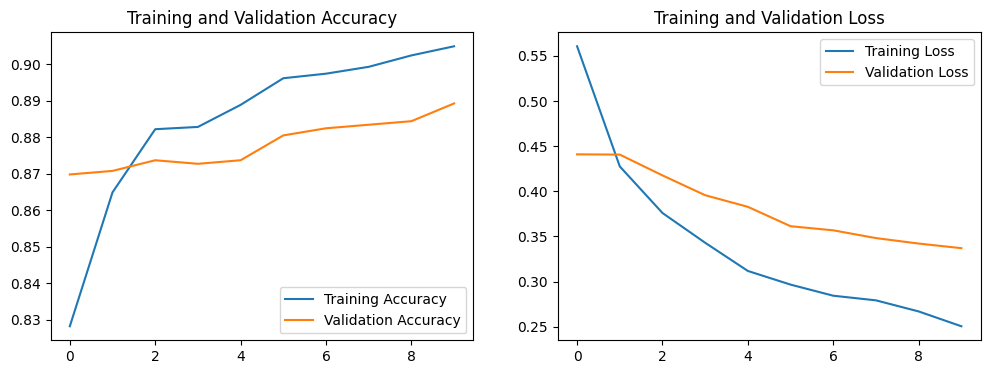

In [20]:
import matplotlib.pyplot as plt

acc = history_ft.history['accuracy']
val_acc = history_ft.history['val_accuracy']

loss = history_ft.history['loss']
val_loss = history_ft.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step


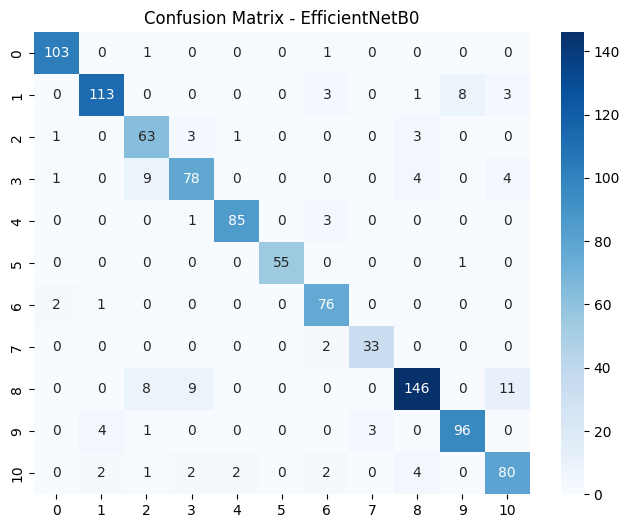

              precision    recall  f1-score   support

         dew       0.96      0.98      0.97       105
     fogsmog       0.94      0.88      0.91       128
       frost       0.76      0.89      0.82        71
       glaze       0.84      0.81      0.83        96
        hail       0.97      0.96      0.96        89
   lightning       1.00      0.98      0.99        56
        rain       0.87      0.96      0.92        79
     rainbow       0.92      0.94      0.93        35
        rime       0.92      0.84      0.88       174
   sandstorm       0.91      0.92      0.92       104
        snow       0.82      0.86      0.84        93

    accuracy                           0.90      1030
   macro avg       0.90      0.91      0.91      1030
weighted avg       0.90      0.90      0.90      1030



In [19]:
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - EfficientNetB0")
plt.show()

print(classification_report(
    y_true, y_pred,
    target_names=test_generator.class_indices.keys()
))
